In [2]:
# Data taken from covidtracking.com

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from datetime import datetime, timedelta
from ipywidgets import interact
import itertools
from tabulate import tabulate

# This is not recommended but I am doing this to suppress warnings from SARIMAX
warnings.simplefilter('ignore')

In [5]:
# Read csv file
USDataFilename = os.path.join('data', 'covidtracking', 'upto05192020', 'daily.csv')
# This is the name of the file previously used
# USDataFilename = os.path.join('data', 'covidtracking', 'upto03242020', 'states-daily.csv')
USCovidFr = pd.read_csv(USDataFilename)
USCovidFr

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200519,AK,399.0,35981.0,NaN,16.0,NaN,NaN,NaN,NaN,...,NaN,36380,36380,36380,2,0.0,0.0,769.0,0.0,769.0
1,20200519,AL,12376.0,145190.0,NaN,NaN,1453.0,NaN,517.0,NaN,...,1453.0,157566,157566,157566,1,15.0,37.0,153.0,290.0,443.0
2,20200519,AR,4923.0,88778.0,NaN,78.0,535.0,NaN,NaN,14.0,...,535.0,93701,93701,93701,5,2.0,5.0,8352.0,110.0,8462.0
3,20200519,AS,0.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,124,124,124,60,0.0,0.0,19.0,0.0,19.0
4,20200519,AZ,14566.0,147005.0,NaN,792.0,1746.0,318.0,NaN,201.0,...,1746.0,161571,161571,161571,4,18.0,29.0,4702.0,396.0,5098.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4212,20200126,WA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,53,0.0,0.0,0.0,0.0,0.0
4213,20200125,WA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,53,0.0,0.0,0.0,0.0,0.0
4214,20200124,WA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,53,0.0,0.0,0.0,0.0,0.0
4215,20200123,WA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,1,1,53,0.0,0.0,0.0,0.0,0.0


# Plot US State data

In [6]:
# Columns to use
colsList = ['positive', 'negative', 'hospitalized', 'death']

# Get dataframe for US State
def getUSStateCovidFr(USStateName):
    USStateCovidFr = USCovidFr[USCovidFr['state'] == USStateName]
    return USStateCovidFr

def convertDateToReadableFormat(dateList):
    dtObjectList = []
    for dateInt in dateList:
        dateStr = str(dateInt)
        x = datetime(int(dateStr[:4]), int(dateStr[4:6]), int(dateStr[6:8]))
        dtObjectList.append(x)
    dateTimeList = [dtObject.strftime('%m/%d/%y') for dtObject in dtObjectList]
    return dateTimeList, dtObjectList

# Function for plotting US state data
def plotUSStateData(USStateName, logScale=False, tablesToUse='all'):
    '''
    tablestoUse is either 'all' or a list of table names from colsList
    '''
    USStateCovidFr = getUSStateCovidFr(USStateName)
    dateList = USStateCovidFr['date'].tolist()
    readableDateList, _ = convertDateToReadableFormat(dateList)
    # Data is latest to oldest
    readableDateList.reverse()
    
    USStateCovidDataDict = {}
    for col in colsList:
        dataList = USStateCovidFr[col].tolist()
        dataList.reverse()
        USStateCovidDataDict[col] = dataList
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    if tablesToUse == 'all':
        for col in colsList:
            ax.plot(readableDateList, USStateCovidDataDict[col], marker='o', label=col);
    else:
        for tableToUse in tablesToUse:
            ax.plot(readableDateList, USStateCovidDataDict[tableToUse], marker='o', label=tableToUse);

    plt.xticks(rotation=45, ha="right");
    
    if logScale:
        plt.yscale('log')

    every_nth = 3
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    ax.legend(loc='upper left');
    plt.title('Data for {}'.format(USStateName), fontsize=26);
    plt.xlabel('Date', fontsize=18);
    plt.ylabel('Number of cases', fontsize=18);
    plt.grid(axis='y')

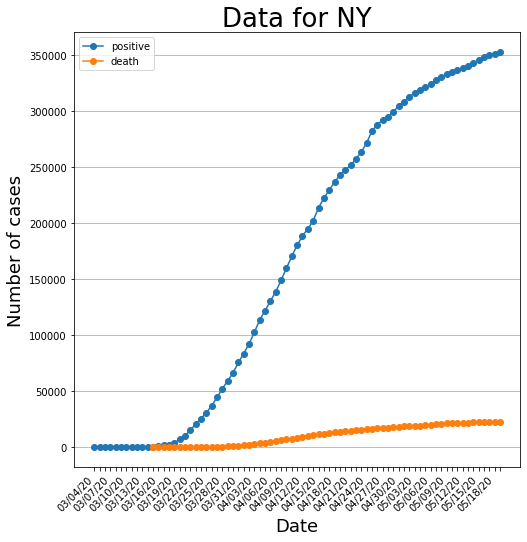

In [7]:
plotUSStateData('NY', tablesToUse=['positive', 'death'])

# Plot data with predictions for next n days

In [8]:
def getPredictionsForFuture_USState(USStateName,
                                    nDays=5,
                                    invertible=False, # Whether model is invertible or not
                                    plot=True,
                                    logScale=False,
                                    grid=None,
                                    printResults=True,
                                    tablesToUse='all',
                                    returnResults=False):
    '''
    tablesToUse is either 'all' for all tables, otherwise use a list containing one or more of 'confirmed', 'recovered' or 'deaths'
    '''
    
    # Extract model parameters
    p, d, q = (1, 2, 2)
    
    USStateCovidFr = getUSStateCovidFr(USStateName)
    dateList = USStateCovidFr['date'].tolist()
    readableDateList, dtObjectList = convertDateToReadableFormat(dateList)
    # Data is latest to oldest
    readableDateList.reverse()
    dtObjectList.reverse()
    
    USStateCovidDataDict = {}
    for col in colsList:
        dataList = USStateCovidFr[col].tolist()
        dataList.reverse()
        USStateCovidDataDict[col] = dataList
    
    plotStartedFlag = False
    if tablesToUse == 'all':
        keysList = USStateCovidFr.keys()
    else:
        keysList = tablesToUse
    allData = {}
    predData = {}
    for key in keysList:
        data = list(USStateCovidDataDict[key])
#         if len(data) == 0:
#             allDataDict = dict(zip(datetimeForPlotList, [0]*len(datetimeForPlotList)))
#             allData[key] = allDataDict
#             continue
            
        predictionsList = []

        for i in range(nDays):
            model = SARIMAX(data, order=(p, d, q), enforce_invertibility=invertible)

            model_fit = model.fit(disp=False)

            # make prediction
            yhat = model_fit.predict(len(data), len(data), typ='levels')

            data.extend(yhat)
            predictionsList.append(yhat[0])
            
        # Required for printing as well as plotting
        dateTimeOjectForPlotList = dtObjectList.copy()
        lastDateTimeObject = dateTimeOjectForPlotList[-1]
        futureDateTimeObjectList = []
        for i in range(nDays):
            lastDateTimeObject += timedelta(days=1)
            dateTimeOjectForPlotList.append(lastDateTimeObject)
            futureDateTimeObjectList.append(lastDateTimeObject)

        datetimeForPlotList = [dateTimeObject.strftime('%m/%d/%y') for dateTimeObject in dateTimeOjectForPlotList]
        futureDateTimeList = [dateTimeObject.strftime('%m/%d/%y') for dateTimeObject in futureDateTimeObjectList]
        
        if printResults:
            print('Predictions for next {} days:'.format(nDays))
            # Round off predictions for printing
            predPrintList = [np.around(elem) for elem in predictionsList]
            datePredList = list(zip(futureDateTimeList, predPrintList))
            # Convert individual elements of zip to a list
            datePredList = [list(elem) for elem in datePredList]
            print(tabulate(datePredList, headers=['Date', 'Prediction'], tablefmt='orgtbl'))
            
                
        if plot:
            # Start a plot if not already started
            if plotStartedFlag == False:
                fig = plt.figure(figsize=(8,8))
                ax = fig.add_subplot(111)
                plotStartedFlag = True
            if logScale:
                for i in range(len(data)):
                    if data[i] == 0:
                        data[i] = np.nan
            ax.plot(datetimeForPlotList, data, marker='o', label=key);
            # Circle predictions
            ax.scatter(futureDateTimeList, predictionsList, s=130, linewidth=2, facecolors='none', edgecolors='k');
        
        allDataDict = dict(zip(datetimeForPlotList, data))
        allData[key] = allDataDict

        predDict = dict(zip(futureDateTimeList, predictionsList))
        predData[key] = predDict
    if plot:
        if logScale:
            plt.yscale('log')
        plt.xticks(rotation=45, ha="right");
        
        every_nth = 4
        for n, label in enumerate(ax.xaxis.get_ticklabels()):
            if n % every_nth != 0:
                label.set_visible(False)
        ax.legend(loc='upper left', prop={'size': 18});
        plt.title('Data for {}\n(Including predictions for next {} days)'.format(USStateName, nDays), fontsize=24);
        plt.xlabel('Date', fontsize=18);
        if logScale:
            plt.ylabel('Number of cases (log scale)', fontsize=18);
        else:
            plt.ylabel('Number of cases', fontsize=18);
        
        if grid != None:
            plt.grid(axis=grid)
        
    if returnResults:
        return allData, predData

Predictions for next 5 days:
| Date     |   Prediction |
|----------+--------------|
| 05/20/20 |       354501 |
| 05/21/20 |       356170 |
| 05/22/20 |       357843 |
| 05/23/20 |       359516 |
| 05/24/20 |       361189 |
Predictions for next 5 days:
| Date     |   Prediction |
|----------+--------------|
| 05/20/20 |        22949 |
| 05/21/20 |        23052 |
| 05/22/20 |        23150 |
| 05/23/20 |        23246 |
| 05/24/20 |        23340 |
Predictions for next 5 days:
| Date     |   Prediction |
|----------+--------------|
| 05/20/20 |        76511 |
| 05/21/20 |        76846 |
| 05/22/20 |        77189 |
| 05/23/20 |        77526 |
| 05/24/20 |        77863 |


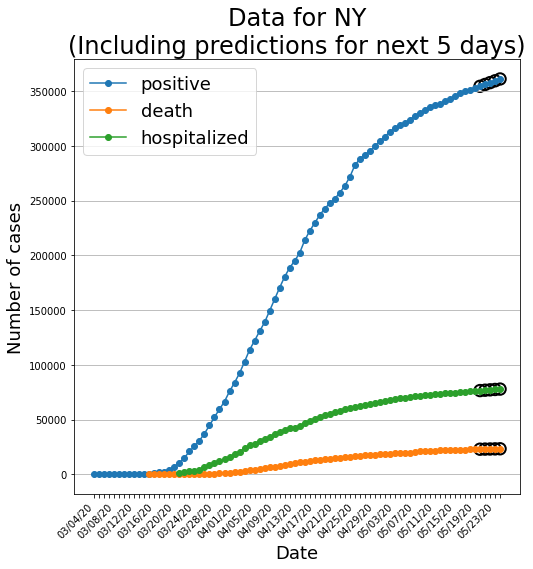

In [9]:
allData, predData = getPredictionsForFuture_USState('NY',
                                                    invertible=False,
                                                    plot=True,
                                                    logScale=False, 
                                                    printResults=True, 
                                                    nDays=5, 
                                                    tablesToUse=['positive', 'death', 'hospitalized'], 
                                                    grid='y',
                                                    returnResults=True)

# Interactive plot to select US state and other parameters

In [10]:
# Sort the list of US states for easier navigation
USStatesCorrectedList = USCovidFr['state'].unique()
USStatesCorrectedList.sort()

# Generate a possible list of all combinations of tables
keysList = colsList
tablesToUseList = []
for i in range(1,len(keysList)+1):
    tablesList = list(itertools.combinations(['positive', 'negative', 'hospitalized', 'death'], i)) # This gives a tuple
    # Convert tuple to list
    tablesList = [list(tablesTuple) for tablesTuple in tablesList]
    # Extend this list
    tablesToUseList.extend(tablesList)

In [11]:
# Wrapper function to ignore certain parameters (such as returnResults and plot) in display
def getPredictionsForFuture_USStateWrapper(USStateName,
                                           nDays=5,
                                           invertible=False, # Whether model is invertible or not
                                           logScale=False,
                                           printResults=True,
                                           tablesToUse='all'):
    getPredictionsForFuture_USState(USStateName,
                                    nDays=nDays,
                                    invertible=invertible, # Whether model is invertible or not
                                    logScale=logScale,
                                    grid='y',
                                    printResults=printResults,
                                    tablesToUse=tablesToUse)
interact(getPredictionsForFuture_USStateWrapper,
         USStateName=USStatesCorrectedList,
         printResults=False,
         plot=True,
         grid='y',
         ndays=list(range(11)),
         invertible=False,
         tablesToUse=tablesToUseList,
         logScale=False,
         returnResults=False);

interactive(children=(Dropdown(description='USStateName', options=('AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', '…

# Compare plots of two or more states

In [12]:
def comparePlotsOfNUSStates(USStateNamesList,
                            nDays=5,
                            invertible=False, # Whether model is invertible or not
                            logScale=False,
                            grid=None,
                            printResults=True,
                            tableToUse='positive'):
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    printListCreatedFlag = False
    for USStateName in USStateNamesList:
        allData, predData = getPredictionsForFuture_USState(USStateName,
                                                            nDays=nDays,
                                                            invertible=invertible,
                                                            plot=False,
                                                            logScale=logScale,
                                                            grid=grid,
                                                            printResults=False,
                                                            tablesToUse=[tableToUse],
                                                            returnResults=True)
        allData = allData[tableToUse]
        predData = predData[tableToUse]
        if logScale:
            for key in allData.keys():
                if allData[key] == 0:
                    allData[key] = np.nan
            
        ax.plot(list(allData.keys()), list(allData.values()), marker='o', label=USStateName);
        
        # Circle predictions
        ax.scatter(list(predData.keys()), list(predData.values()), s=130, linewidth=2, facecolors='none', edgecolors='k');
        
        if printListCreatedFlag == False:
            printListCreatedFlag = True
            
            futureDateTimeList = list(predData.keys())
            predictionsList = list(predData.values())
            predPrintList = [np.around(elem) for elem in predictionsList]
            
            # Zip dates and predictions together
            datePredList = list(zip(futureDateTimeList, predPrintList))
            # Convert individual elements of zip to a list
            datePredList = [list(elem) for elem in datePredList]
        else:
            predictionsList = list(predData.values())
            for i in range(len(datePredList)):
                datePredList[i].append(np.around(predictionsList[i]))
            
    if printResults:
        headerList = ['Date']
        headerList.extend(USStateNamesList)
        print(tabulate(datePredList, headers=headerList, tablefmt='orgtbl'))
            
        
    plt.xticks(rotation=45, ha="right");
    if logScale:
        plt.yscale('log')
        
    every_nth = 4
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)
    ax.legend(loc='upper left', prop={'size': 18});
    
    plt.title('Covid-19 Data\n(Including predictions for next {} days)'.format(nDays), fontsize=24);
    plt.xlabel('Date', fontsize=18);
    if logScale:
        if tableToUse == 'positive':
            plt.ylabel('Number of confirmed cases (log scale)', fontsize=18);
        elif tableToUse == 'death':
            plt.ylabel('Number of deaths (log scale)', fontsize=18);
        else:
            plt.ylabel('Number of cases (log scale)', fontsize=18);
    else:
        if tableToUse == 'positive':
            plt.ylabel('Number of confirmed cases', fontsize=18);
        elif tableToUse == 'death':
            plt.ylabel('Number of deaths', fontsize=18);
        else:
            plt.ylabel('Number of cases', fontsize=18);
        
    if grid != None:
        plt.grid(axis=grid)

| Date     |    NY |    NJ |   CA |   TX |
|----------+-------+-------+------+------|
| 05/20/20 | 22949 | 10743 | 3381 | 1397 |
| 05/21/20 | 23052 | 10895 | 3436 | 1426 |
| 05/22/20 | 23150 | 11045 | 3493 | 1455 |
| 05/23/20 | 23246 | 11196 | 3550 | 1485 |
| 05/24/20 | 23340 | 11346 | 3608 | 1514 |


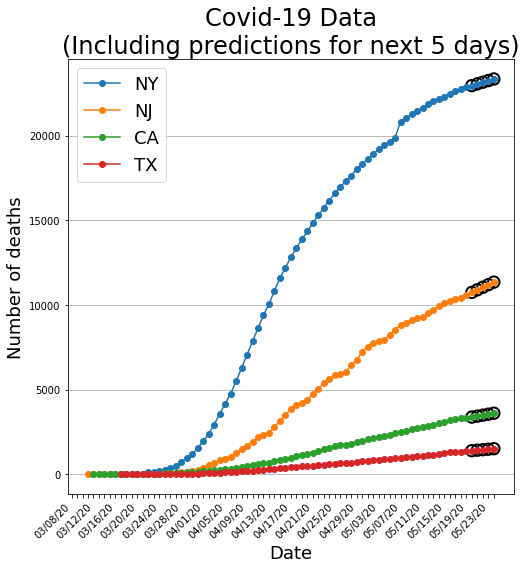

In [15]:
comparePlotsOfNUSStates(['NY', 'NJ', 'CA', 'TX'], nDays=5, grid='y', logScale=False, tableToUse='death')

In [11]:
# Interactive plot to compare data from 2 US states
def comparePlotsOf2USSTatesWrapper(USStateName1,
                                   USStateName2,
                                   nDays=5,
                                   invertible=True, # Whether model is invertible or not
                                   logScale=False,
                                   printResults=True,
                                   tableToUse='positive'):
    
    USStateNameList = [USStateName1, USStateName2]
    comparePlotsOfNUSStates(USStateNameList,
                            nDays=nDays,
                            invertible=invertible, # Whether model is invertible or not
                            logScale=logScale,
                            grid='y',
                            printResults=printResults,
                            tableToUse=tableToUse)
    plt.title('Data for {} and {}\n(Including predictions for next {} days)'.format(USStateName1,
                                                                                    USStateName2,
                                                                                    nDays),
              fontsize=24)
    
interact(comparePlotsOf2USSTatesWrapper,
         USStateName1=USStatesCorrectedList,
         USStateName2=USStatesCorrectedList,
         printResults=True,
         ndays=list(range(11)),
         invertible=False,
         tableToUse=colsList,
         logScale=False);

interactive(children=(Dropdown(description='USStateName1', options=('AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', …

# Plot of new cases per day since n = 100th case

| Date     |   NY |   CA |   WA |   TX |
|----------+------+------+------+------|
| 05/05/20 | 7311 | 1511 |  277 |  839 |
| 05/06/20 | 7506 | 1500 |  254 |  825 |
| 05/07/20 | 7740 | 1559 |  263 |  820 |
| 05/08/20 | 7915 | 1586 |  255 |  818 |
| 05/09/20 | 8129 | 1627 |  256 |  817 |


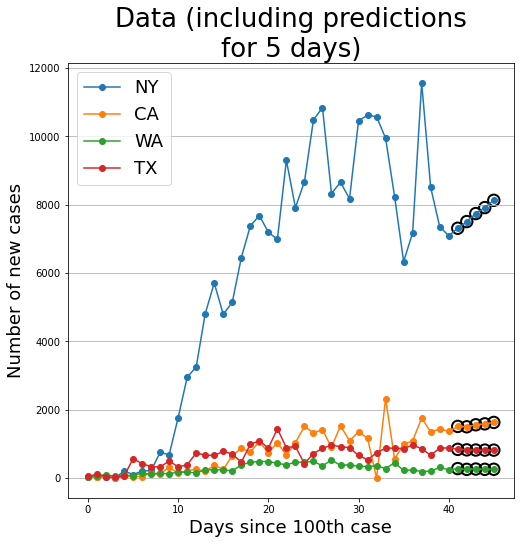

In [12]:
def comparePlotDaysSinceNCases_showNewCasesPerDay_USStates(USStateNamesList,
                                                           logScale=False,
                                                           daysSince=100,
                                                           invertible=False,
                                                           nDaysPrediction=5,
                                                           timeSeriesLim = 40, # Limit size of data to 40 points only
                                                           printResults=True):
    p, d, q = (1, 2, 2)
    plotStartedFlag = False
    printListCreatedFlag = False
    for USStateName in USStateNamesList:
        allData, predData = getPredictionsForFuture_USState(USStateName,
                                                            nDays=0,
                                                            invertible=False, # Whether model is invertible or not
                                                            plot=False,
                                                            logScale=False,
                                                            grid=None,
                                                            printResults=False,
                                                            tablesToUse=['positive'],
                                                            returnResults=True)
        USStateConfirmedFr =  allData['positive']
        
        nCasesGreaterDaysSinceList = []
        datesGreaterDaysSinceList = []
        for key in USStateConfirmedFr.keys():
            if USStateConfirmedFr[key] > daysSince:
                datesGreaterDaysSinceList.append(key)
                nCasesGreaterDaysSinceList.append(USStateConfirmedFr[key])
                
        casesPerDayList = [t - s for s, t in zip(nCasesGreaterDaysSinceList, nCasesGreaterDaysSinceList[1:])]
        
        lastDateAvailable = datesGreaterDaysSinceList[-1]
        lastDateAvailableDateTimeObject = datetime.strptime(lastDateAvailable, '%m/%d/%y')
        
        data = casesPerDayList
        if len(data) > timeSeriesLim:
            data = data[:timeSeriesLim+1]
        predictionsList = []
        predictionPointsXCoordinateList = list(range(len(data), len(data)+nDaysPrediction))

        for i in range(nDaysPrediction):
            model = SARIMAX(data, order=(p, d, q), enforce_invertibility=invertible)

            model_fit = model.fit(disp=False)

            # make prediction
            yhat = model_fit.predict(len(data), len(data), typ='levels')

            data.extend(yhat)
            predictionsList.append(yhat[0])

        if printListCreatedFlag == False:
            printListCreatedFlag = True

            futureDateTimeObjectList = []
            for i in range(nDaysPrediction):
                lastDateAvailableDateTimeObject += timedelta(days=1)
                futureDateTimeObjectList.append(lastDateAvailableDateTimeObject)
            futureDateTimeList = [dateTimeObject.strftime('%m/%d/%y') for dateTimeObject in futureDateTimeObjectList]

            predPrintList = [np.around(elem) for elem in predictionsList]

            # Zip dates and predictions together
            datePredList = list(zip(futureDateTimeList, predPrintList))
            # Convert individual elements of zip to a list
            datePredList = [list(elem) for elem in datePredList]
        else:
            for i in range(len(datePredList)):
                datePredList[i].append(np.around(predictionsList[i]))
        
        if plotStartedFlag == False:
            fig = plt.figure(figsize=(8,8))
            ax = fig.add_subplot(111)
            plotStartedFlag = True
        if logScale:
            for i in range(len(data)):
                if data[i] == 0:
                    data[i] = np.nan
        ax.plot(data, marker='o', label=USStateName);
        

        # Circle predictions
        ax.scatter(predictionPointsXCoordinateList, predictionsList, s=130, linewidth=2, facecolors='none', edgecolors='k');
        
    if printResults:
        
        headerList = ['Date']
        for USStateName in USStateNamesList:
            headerList.append(USStateName)
                
        print(tabulate(datePredList, headers=headerList, tablefmt='orgtbl'))
        
    ax.legend(loc='upper left', prop={'size': 18});
#     plt.title('Data for {}'.format(countryName), fontsize=26);
    plt.title('Data (including predictions\nfor {} days)'.format(nDaysPrediction), fontsize=26);
    plt.xlabel('Days since {}th case'.format(daysSince), fontsize=18);
    plt.ylabel('Number of new cases', fontsize=18);
    plt.grid(axis='y')
    
    if logScale:
        plt.yscale('log')
        
comparePlotDaysSinceNCases_showNewCasesPerDay_USStates(['NY', 'CA', 'WA', 'TX'], daysSince=100, logScale=False)